In [1]:
import fiona
from shapely.geometry import shape, mapping
import os
import json
import geopandas as gpd
import numpy as np

# From Trampush et al., 2014
Trampush_velocities = {
    '50':1.2843137254901962,
    '25':0.8413867822318526,
    '75':1.6939077776156426
}

Nienhus_Global_Delta_Database = os.path.join('3rd_party', 
                                             'Nienhus_Global_Delta_Database', 
                                             'Nienhus_Global_Delta_Drainage.geojson')

av_db = os.path.join('avulsion_locations', 'avulsion_location_db.shp')

poly_buffer_features = []

avulsion_buffer_json = {"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::4326" }},
"features": False}


with fiona.open(av_db, 'r') as av_dv_src:
    for av in av_dv_src:
        poly_buffer_features.append({'type':'Feature', 'properties':av['properties'],
                         'geometry': mapping(shape(av['geometry']).buffer(0.01))})

avulsion_buffer_json['features'] = poly_buffer_features

with open('avulsion_locations/Avulsion_Buffers_0_01_degrees.geojson', 'w') as outfile:
    outfile.write(json.dumps(avulsion_buffer_json, indent=4))
    

av_buffer = gpd.read_file('avulsion_locations/Avulsion_Buffers_0_01_degrees.geojson')
NGDD = gpd.read_file(Nienhus_Global_Delta_Database)
av_table = gpd.read_file(av_db)

av_drainage = gpd.sjoin(NGDD, av_buffer, how="inner", op='intersects')
# av_drainage.geometry = av_table.geometry

out_ngdd_drainage = os.path.join('3rd_party', 
                             'Nienhus_Global_Delta_Database', 
                             'Avulsion_Catchments_Nienhus.geojson')

av_drainage.to_file(out_ngdd_drainage, driver='GeoJSON')

print(av_drainage.head())

      BasinID  QRiver_prist   QRiver_dist        QWave         QTide  \
550      7000     14.095327     15.356614  2078.083496      0.076973   
628      9447   8134.100000   8069.800000  5401.212158    632.367493   
859     20041  33631.000000    672.620000  1604.257355    950.653503   
1046    26855  19594.000000  19474.000000  2084.000000  23385.772201   
2284    76565     50.716552     47.210095   435.633392     16.444992   

                                               geometry  index_right  id  \
550   POLYGON ((-70.39583 10.55417, -70.40074 10.582...            1   2   
628   POLYGON ((-76.15000 1.58333, -76.19583 1.57500...           21  22   
859   POLYGON ((28.50000 4.35833, 28.49510 4.32589, ...           14  15   
1046  POLYGON ((-63.45417 3.96250, -63.41605 3.91297...           19  20   
2284  POLYGON ((-79.46667 -3.89583, -79.45833 -3.927...            0   1   

          River      Av_ID  
550     Mitrare     SA0210  
628   Magdalena  Magdalena  
859        Nile       N

In [2]:
# Collate slopes
import pickle
import pandas as pd

# Global data
S2_l_scour_table = pd.read_csv(os.path.join('3rd_party', 'S2_l_scour_table_plus_madagascar.csv'))

filehandler = open('avulsion_upstream_slopes.pkl', 'rb')
upstream_slopes = pickle.load(filehandler)

del S2_l_scour_table['River']

av_drainage = gpd.read_file(out_ngdd_drainage)

av_merged = av_drainage.set_index('Av_ID').join(S2_l_scour_table.set_index('Av_ID'))

del av_merged['geometry']

hydro_shed_data = pd.read_csv("HydroSHEDS/hydro_river_closest_segments.csv", encoding='utf-8')
del hydro_shed_data['geometry']

av_merged = av_merged.join(hydro_shed_data.set_index('RIVER_ID'))

mt_Depth = lambda Q: np.power(0.12*Q, 0.38) # Moody and Troutman, 2002

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

def add_MT_depth(row): # Moody and Troutman, 2002
    return mt_Depth(row['DIS_AV_CMS']) # From Hydrosheds

Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)

def add_KJ_depth(row): # Dunne and Jerolmack, 2018
    return Hbf_Dunne(row['S [-]'], 8, 1000, g)

def add_1ms_depth_25(row): # Assuming a flow of 1ms
    velocity_25 = Trampush_velocities['25']
    return row['DIS_AV_CMS']/velocity_25/row['Width [m]']

def add_1ms_depth_50(row): # Assuming a flow of 1ms
    velocity_50 = Trampush_velocities['50']
    return row['DIS_AV_CMS']/velocity_50/row['Width [m]']
    
def add_1ms_depth_75(row): # Assuming a flow of 1ms
    velocity_75 = Trampush_velocities['75']
    return row['DIS_AV_CMS']/velocity_75/row['Width [m]']
    
def check_slope(row):
    if row['S [-]'] == 0:
        return float(upstream_slopes[row.name]['mean'])
    else:
        return row['S [-]']
    
def check_slope_error(row):
    if row['S [-]'] == 0:
        return float(upstream_slopes[row.name]['std'])
    else:
        return 0
    
def check_Lb_rec(row):
    return row['L_b [km]']

def check_Lb_MT(row):
    return (row['Hbf [m] (M&T, 2002)']/row['S [-]'])/1000

def check_Lb_KJ(row):
    return (row['Hbf [m] (K&J, 2018)']/row['S [-]'])/1000

def check_Lb_1ms_depth_25(row): # Exports in km
    return (row['Hbf [m] (1ms 25)']/row['S [-]'])/1000

def check_Lb_1ms_depth_50(row):
    return (row['Hbf [m] (1ms 50)']/row['S [-]'])/1000

def check_Lb_1ms_depth_75(row):
    return (row['Hbf [m] (1ms 75)']/row['S [-]'])/1000

av_merged['S_std [-]'] = av_merged.apply(check_slope_error, axis=1)    
av_merged['S [-]'] = av_merged.apply(check_slope, axis=1)
av_merged['Hbf [m] (M&T, 2002)'] = av_merged.apply(add_MT_depth, axis=1)    
av_merged['Hbf [m] (K&J, 2018)'] = av_merged.apply(add_KJ_depth, axis=1) 
av_merged['Lb [km] (recorded)'] = av_merged.apply(check_Lb_rec, axis=1)
av_merged['Lb [km] (M&T, 2002)'] = av_merged.apply(check_Lb_MT, axis=1)
av_merged['Lb [km] (K&J, 2018)'] = av_merged.apply(check_Lb_KJ, axis=1)

del S2_l_scour_table['L_b [km]']


In [3]:
# Collate Widths

av_width_db = gpd.read_file(os.path.join('avulsion_locations', 'avulsion_upstream_widths.shp'))

av_width_table = pd.DataFrame({'River':av_width_db['River'], 'Width [m]':av_width_db['width']})

av_merged = av_merged.join(av_width_table.set_index('River'))

av_merged['Hbf [m] (1ms 25)'] = av_merged.apply(add_1ms_depth_25, axis=1) 
av_merged['Hbf [m] (1ms 50)'] = av_merged.apply(add_1ms_depth_50, axis=1) 
av_merged['Hbf [m] (1ms 75)'] = av_merged.apply(add_1ms_depth_75, axis=1) 
av_merged['Lb [km] (1ms 25)'] = av_merged.apply(check_Lb_1ms_depth_25, axis=1)
av_merged['Lb [km] (1ms 50)'] = av_merged.apply(check_Lb_1ms_depth_50, axis=1)
av_merged['Lb [km] (1ms 75)'] = av_merged.apply(check_Lb_1ms_depth_75, axis=1)


print(av_merged.head())


           BasinID  QRiver_prist   QRiver_dist        QWave         QTide  \
Av_ID                                                                       
SA0210        7000     14.095327     15.356614  2078.083496      0.076973   
Magdalena     9447   8134.100000   8069.800000  5401.212158    632.367493   
Nile         20041  33631.000000    672.620000  1604.257355    950.653503   
Orinoco      26855  19594.000000  19474.000000  2084.000000  23385.772201   
SA0505       76565     50.716552     47.210095   435.633392     16.444992   

           index_right  id      River    From  LA [km]  ...  \
Av_ID                                                   ...   
SA0210               1   2    Mitrare   study   16.940  ...   
Magdalena           21  22  Magdalena  global   67.000  ...   
Nile                14  15       Nile  global  210.000  ...   
Orinoco             19  20    Orinoco  global   78.000  ...   
SA0505               0   1     Tumbes   study   10.908  ...   

           Lb [km]

In [4]:
# For missing depth 
import numpy as np
import math

a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)

# Ma et al., 2017
def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + math.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + math.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

def add_D50_MT(row): # Using Trampush et al. 2014 relation
    return float(D50_trampush(row['Hbf [m] (M&T, 2002)'], row['S [-]']))/float(1000)

def add_D50_KJ(row): # Using Trampush et al. 2014 relation
    return float(D50_trampush(row['Hbf [m] (K&J, 2018)'], row['S [-]']))/float(1000)

def add_D50_1ms_25(row): # Using Trampush et al. 2014 relation
    return float(D50_trampush(row['Hbf [m] (1ms 25)'], row['S [-]']))/float(1000)

def add_D50_1ms_50(row): # Using Trampush et al. 2014 relation
    return float(D50_trampush(row['Hbf [m] (1ms 50)'], row['S [-]']))/float(1000)

def add_D50_1ms_75(row): # Using Trampush et al. 2014 relation
    return float(D50_trampush(row['Hbf [m] (1ms 75)'], row['S [-]']))/float(1000)


def Qs_m3_sec(row):
    ps = 2650 # submerged density
    Qs_m3_sec = float(row['QRiver_prist'])/ps
    return Qs_m3_sec

def t_adj_recorded(row):
    
    if row['Hbf [m] (recorded)'] > 0:
        m2_per_s = float(row['Qs WBMSed [cumecs]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
        Lb = float(row['Lb [km] (recorded)'])*1000 # m
        hbf = float(row['Hbf [m] (recorded)']) # m 
        t_adj_s = (hbf*Lb)/(m2_per_s)
        return t_adj_s
    else:
        return 0

def t_adj_ma_recorded(row): 
    
    if row['Hbf [m] (recorded)'] > 0:

        m2_per_s = float(row['Qs Ma, 2017 [cumecs] {rec}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
        Lb = float(row['Lb [km] (recorded)'])*1000 # m
        hbf = float(row['Hbf [m] (recorded)']) # m 
        t_adj_s = (hbf*Lb)/(m2_per_s)

        return t_adj_s
    else:
        return 0

def t_adj_MT(row):
    m2_per_s = float(row['Qs WBMSed [cumecs]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (M&T, 2002)'])*1000 # m
    hbf = float(row['Hbf [m] (M&T, 2002)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_ma_MT(row): 
    
    m2_per_s = float(row['Qs Ma, 2017 [cumecs] {MT}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (M&T, 2002)'])*1000 # m
    hbf = float(row['Hbf [m] (M&T, 2002)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_KJ(row):
    
    m2_per_s = float(row['Qs WBMSed [cumecs]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (K&J, 2018)'])*1000 # m
    hbf = float(row['Hbf [m] (K&J, 2018)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_ma_KJ(row): 
    
    m2_per_s = float(row['Qs Ma, 2017 [cumecs] {KJ}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (K&J, 2018)'])*1000 # m
    hbf = float(row['Hbf [m] (K&J, 2018)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_1ms_25(row):
    m2_per_s = float(row['Qs WBMSed [cumecs]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (1ms 25)'])*1000 # m
    hbf = float(row['Hbf [m] (1ms 25)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_1ms_50(row):
    m2_per_s = float(row['Qs WBMSed [cumecs]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (1ms 50)'])*1000 # m
    hbf = float(row['Hbf [m] (1ms 50)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_1ms_75(row):
    m2_per_s = float(row['Qs WBMSed [cumecs]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (1ms 75)'])*1000 # m
    hbf = float(row['Hbf [m] (1ms 75)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_ma_1ms_25(row):
    m2_per_s = float(row['Qs Ma, 2017 [cumecs] {1ms 25}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (1ms 25)'])*1000 # m
    hbf = float(row['Hbf [m] (1ms 25)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_ma_1ms_50(row):
    m2_per_s = float(row['Qs Ma, 2017 [cumecs] {1ms 50}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (1ms 50)'])*1000 # m
    hbf = float(row['Hbf [m] (1ms 50)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_ma_1ms_75(row):
    m2_per_s = float(row['Qs Ma, 2017 [cumecs] {1ms 75}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (1ms 75)'])*1000 # m
    hbf = float(row['Hbf [m] (1ms 75)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def t_adj_ma_MT(row): 
    
    m2_per_s = float(row['Qs Ma, 2017 [cumecs] {MT}'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['Lb [km] (M&T, 2002)'])*1000 # m
    hbf = float(row['Hbf [m] (M&T, 2002)']) # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    return t_adj_s

def Lscour_WBMSed_recorded(row):
    # Just pretend for now tscour = 1 month
    if row['Lb [km] (recorded)'] > 0:
        return ((row['Lb [km] (recorded)']*1000)*np.sqrt(((2.628e+6*row['t_scour [months]'])/row['T_adj (WBMSed) [s] {rec}'])))/1000
    else:
        return 0

def Lscour_ma_recorded(row):
    # Just pretend for now tscour = 1 month
    if row['Lb [km] (recorded)'] > 0:
        return ((row['Lb [km] (recorded)']*1000)*np.sqrt(((2.628e+6*row['t_scour [months]'])/row['T_adj (Ma, 2017) [s] {rec}'])))/1000
    else:
        return 0
    
def Lscour_full_recorded(row):
    
    if (row['Hbf [m] (recorded)'] > 0) & (row['D50 [m] (recorded)'] > 0):
        
        a_ma_rep = a_Ma(row['D50 [m] (recorded)'])
        n_ma_rep = n_Ma(row['D50 [m] (recorded)']) 
        
        lscour_top = np.sqrt(R*g*(np.power(row['D50 [m] (recorded)'],3)))*a_ma_rep*np.power((row['Hbf [m] (recorded)']*3)*row['S [-]'], n_ma_rep)
        lscour_bottom = row['Hbf [m] (recorded)']*(row['Lb [km] (recorded)']*1000)*row['Cf']*np.power(R*row['D50 [m] (recorded)'],n_ma_rep)
        lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*(row['Lb [km] (recorded)']*1000)

        return lscour_rep/1000
    else:
        return 0

def Lscour_WBMSed_MT(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (M&T, 2002)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (WBMSed) [s] {MT}']))/1000

def Lscour_ma_MT(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (M&T, 2002)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (Ma, 2017) [s] {MT}']))/1000

def Lscour_full_MT(row):
    
    if row['D50 [m] (M&T, 2002)'] > 0:
        a_ma_rep = a_Ma(row['D50 [m] (M&T, 2002)'])
        n_ma_rep = n_Ma(row['D50 [m] (M&T, 2002)']) 
        
        lscour_top = np.sqrt(R*g*(np.power(row['D50 [m] (M&T, 2002)'],3)))*a_ma_rep*np.power((row['Hbf [m] (M&T, 2002)']*3)*row['S [-]'], n_ma_rep)
        lscour_bottom = row['Hbf [m] (M&T, 2002)']*(row['Lb [km] (M&T, 2002)']*1000)*row['Cf']*np.power(R*row['D50 [m] (M&T, 2002)'],n_ma_rep)
        lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*(row['Lb [km] (M&T, 2002)']*1000)

        return lscour_rep/1000

def Lscour_WBMSed_KJ(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (K&J, 2018)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (WBMSed) [s] {KJ}']))/1000

def Lscour_ma_KJ(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (K&J, 2018)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (Ma, 2017) [s] {KJ}']))/1000

def Lscour_full_KJ(row):
    
    if row['D50 [m] (K&J, 2018)'] > 0:
        a_ma_rep = a_Ma(row['D50 [m] (K&J, 2018)'])
        n_ma_rep = n_Ma(row['D50 [m] (K&J, 2018)']) 
        
        lscour_top = np.sqrt(R*g*(np.power(row['D50 [m] (K&J, 2018)'],3)))*a_ma_rep*np.power((row['Hbf [m] (K&J, 2018)']*3)*row['S [-]'], n_ma_rep)
        lscour_bottom = row['Hbf [m] (K&J, 2018)']*(row['Lb [km] (K&J, 2018)']*1000)*row['Cf']*np.power(R*row['D50 [m] (K&J, 2018)'],n_ma_rep)
        lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*(row['Lb [km] (K&J, 2018)']*1000)

        return lscour_rep/1000

def Lscour_WBMSed_1ms_25(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (1ms 25)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (WBMSed) [s] {1ms 25}']))/1000

def Lscour_ma_1ms_25(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (1ms 25)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (Ma, 2017) [s] {1ms 25}']))/1000

def Lscour_full_1ms_25(row):
    
    if row['D50 [m] (1ms 25)'] > 0:
        a_ma_rep = a_Ma(row['D50 [m] (1ms 25)'])
        n_ma_rep = n_Ma(row['D50 [m] (1ms 25)']) 
        
        lscour_top = np.sqrt(R*g*(np.power(row['D50 [m] (1ms 25)'],3)))*a_ma_rep*np.power((row['Hbf [m] (1ms 25)']*3)*row['S [-]'], n_ma_rep)
        lscour_bottom = row['Hbf [m] (1ms 25)']*(row['Lb [km] (1ms 25)']*1000)*row['Cf']*np.power(R*row['D50 [m] (1ms 25)'],n_ma_rep)
        lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*(row['Lb [km] (1ms 25)']*1000)

        return lscour_rep/1000
    
    
def Lscour_WBMSed_1ms_50(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (1ms 50)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (WBMSed) [s] {1ms 50}']))/1000

def Lscour_ma_1ms_50(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (1ms 50)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (Ma, 2017) [s] {1ms 50}']))/1000

def Lscour_full_1ms_50(row):
    
    if row['D50 [m] (1ms 50)'] > 0:
        a_ma_rep = a_Ma(row['D50 [m] (1ms 50)'])
        n_ma_rep = n_Ma(row['D50 [m] (1ms 50)']) 
        
        lscour_top = np.sqrt(R*g*(np.power(row['D50 [m] (1ms 50)'],3)))*a_ma_rep*np.power((row['Hbf [m] (1ms 50)']*3)*row['S [-]'], n_ma_rep)
        lscour_bottom = row['Hbf [m] (1ms 50)']*(row['Lb [km] (1ms 50)']*1000)*row['Cf']*np.power(R*row['D50 [m] (1ms 50)'],n_ma_rep)
        lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*(row['Lb [km] (1ms 50)']*1000)

        return lscour_rep/1000

def Lscour_WBMSed_1ms_75(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (1ms 75)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (WBMSed) [s] {1ms 75}']))/1000

def Lscour_ma_1ms_75(row):
    # Just pretend for now tscour = 1 month
    return ((row['Lb [km] (1ms 75)']*1000)*np.sqrt(((3.154e+7/12)*1.5)/row['T_adj (Ma, 2017) [s] {1ms 75}']))/1000

def Lscour_full_1ms_75(row):
    
    if row['D50 [m] (1ms 75)'] > 0:
        a_ma_rep = a_Ma(row['D50 [m] (1ms 75)'])
        n_ma_rep = n_Ma(row['D50 [m] (1ms 75)']) 
        
        lscour_top = np.sqrt(R*g*(np.power(row['D50 [m] (1ms 75)'],3)))*a_ma_rep*np.power((row['Hbf [m] (1ms 75)']*3)*row['S [-]'], n_ma_rep)
        lscour_bottom = row['Hbf [m] (1ms 75)']*(row['Lb [km] (1ms 75)']*1000)*row['Cf']*np.power(R*row['D50 [m] (1ms 75)'],n_ma_rep)
        lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
        lscour_rep = lscour_Lb*(row['Lb [km] (1ms 75)']*1000)

        return lscour_rep/1000
    
def Qs_Ma_rec(row):
            
    if (row['Hbf [m] (recorded)'] > 0) & (row['D50 [m] (recorded)'] > 0):

        a_ma_rep = a_Ma(row['D50 [m] (recorded)'])
        n_ma_rep = n_Ma(row['D50 [m] (recorded)'])        
        tau_star = ((row['Hbf [m] (recorded)']*3)*row['S [-]'])/(R*row['D50 [m] (recorded)'])

        qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
        qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m] (recorded)'],3))
        return qs*row['Width [m]']
        
    else:
        return 0

def Qs_Ma_MT(row):
            
    a_ma_rep = a_Ma(row['D50 [m] (M&T, 2002)'])
    n_ma_rep = n_Ma(row['D50 [m] (M&T, 2002)'])        
    tau_star = ((row['Hbf [m] (M&T, 2002)']*3)*row['S [-]'])/(R*row['D50 [m] (M&T, 2002)'])

    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m] (M&T, 2002)'],3))
    return qs*row['Width [m]']

def Qs_Ma_KJ(row):
            
    a_ma_rep = a_Ma(row['D50 [m] (K&J, 2018)'])
    n_ma_rep = n_Ma(row['D50 [m] (K&J, 2018)'])        
    tau_star = ((row['Hbf [m] (K&J, 2018)']*3)*row['S [-]'])/(R*row['D50 [m] (K&J, 2018)'])

    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m] (K&J, 2018)'],3))
    return qs*row['Width [m]']


def Qs_Ma_1ms_25(row):
            
    a_ma_rep = a_Ma(row['D50 [m] (1ms 25)'])
    n_ma_rep = n_Ma(row['D50 [m] (1ms 25)'])        
    tau_star = ((row['Hbf [m] (1ms 25)']*3)*row['S [-]'])/(R*row['D50 [m] (1ms 25)'])

    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m] (1ms 25)'],3))
    return qs*row['Width [m]']


def Qs_Ma_1ms_50(row):
            
    a_ma_rep = a_Ma(row['D50 [m] (1ms 50)'])
    n_ma_rep = n_Ma(row['D50 [m] (1ms 50)'])        
    tau_star = ((row['Hbf [m] (1ms 50)']*3)*row['S [-]'])/(R*row['D50 [m] (1ms 50)'])

    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m] (1ms 50)'],3))
    return qs*row['Width [m]']

    
def Qs_Ma_1ms_75(row):
            
    a_ma_rep = a_Ma(row['D50 [m] (1ms 75)'])
    n_ma_rep = n_Ma(row['D50 [m] (1ms 75)'])        
    tau_star = ((row['Hbf [m] (1ms 75)']*3)*row['S [-]'])/(R*row['D50 [m] (1ms 75)'])

    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m] (1ms 75)'],3))
    return qs*row['Width [m]']
        
    
av_merged['D50 [m] (M&T, 2002)'] = av_merged.apply(add_D50_MT, axis=1)
av_merged['D50 [m] (K&J, 2018)'] = av_merged.apply(add_D50_KJ, axis=1)
av_merged['D50 [m] (1ms 25)'] = av_merged.apply(add_D50_1ms_25, axis=1)
av_merged['D50 [m] (1ms 50)'] = av_merged.apply(add_D50_1ms_50, axis=1)
av_merged['D50 [m] (1ms 75)'] = av_merged.apply(add_D50_1ms_75, axis=1)


av_merged['Qs WBMSed [cumecs]'] = av_merged.apply(Qs_m3_sec, axis=1)
av_merged['Qs Ma, 2017 [cumecs] {rec}'] = av_merged.apply(Qs_Ma_rec, axis=1)
av_merged['Qs Ma, 2017 [cumecs] {MT}'] = av_merged.apply(Qs_Ma_MT, axis=1)
av_merged['Qs Ma, 2017 [cumecs] {KJ}'] = av_merged.apply(Qs_Ma_KJ, axis=1)
av_merged['Qs Ma, 2017 [cumecs] {1ms 25}'] = av_merged.apply(Qs_Ma_1ms_25, axis=1)
av_merged['Qs Ma, 2017 [cumecs] {1ms 50}'] = av_merged.apply(Qs_Ma_1ms_50, axis=1)
av_merged['Qs Ma, 2017 [cumecs] {1ms 75}'] = av_merged.apply(Qs_Ma_1ms_75, axis=1)

av_merged['T_adj (WBMSed) [s] {rec}'] = av_merged.apply(t_adj_recorded, axis=1)
av_merged['T_adj (WBMSed) [y] {rec}'] = av_merged['T_adj (WBMSed) [s] {rec}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {rec}'] = av_merged.apply(t_adj_ma_recorded, axis=1)
av_merged['T_adj (Ma, 2017) [y] {rec}'] = av_merged['T_adj (Ma, 2017) [s] {rec}']/3.154e+7 

av_merged['T_adj (WBMSed) [s] {MT}'] = av_merged.apply(t_adj_MT, axis=1)
av_merged['T_adj (WBMSed) [y] {MT}'] = av_merged['T_adj (WBMSed) [s] {MT}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {MT}'] = av_merged.apply(t_adj_ma_MT, axis=1)
av_merged['T_adj (Ma, 2017) [y] {MT}'] = av_merged['T_adj (Ma, 2017) [s] {MT}']/3.154e+7 

av_merged['T_adj (WBMSed) [s] {KJ}'] = av_merged.apply(t_adj_KJ, axis=1)
av_merged['T_adj (WBMSed) [y] {KJ}'] = av_merged['T_adj (WBMSed) [s] {KJ}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {KJ}'] = av_merged.apply(t_adj_ma_KJ, axis=1)
av_merged['T_adj (Ma, 2017) [y] {KJ}'] = av_merged['T_adj (Ma, 2017) [s] {KJ}']/3.154e+7 

av_merged['T_adj (WBMSed) [s] {KJ}'] = av_merged.apply(t_adj_KJ, axis=1)
av_merged['T_adj (WBMSed) [y] {KJ}'] = av_merged['T_adj (WBMSed) [s] {KJ}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {KJ}'] = av_merged.apply(t_adj_ma_KJ, axis=1)
av_merged['T_adj (Ma, 2017) [y] {KJ}'] = av_merged['T_adj (Ma, 2017) [s] {KJ}']/3.154e+7 

av_merged['T_adj (WBMSed) [s] {1ms 25}'] = av_merged.apply(t_adj_1ms_25, axis=1)
av_merged['T_adj (WBMSed) [y] {1ms 25}'] = av_merged['T_adj (WBMSed) [s] {1ms 25}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {1ms 25}'] = av_merged.apply(t_adj_ma_1ms_25, axis=1)
av_merged['T_adj (Ma, 2017) [y] {1ms 25}'] = av_merged['T_adj (Ma, 2017) [s] {1ms 25}']/3.154e+7 

av_merged['T_adj (WBMSed) [s] {1ms 50}'] = av_merged.apply(t_adj_1ms_50, axis=1)
av_merged['T_adj (WBMSed) [y] {1ms 50}'] = av_merged['T_adj (WBMSed) [s] {1ms 50}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {1ms 50}'] = av_merged.apply(t_adj_ma_1ms_50, axis=1)
av_merged['T_adj (Ma, 2017) [y] {1ms 50}'] = av_merged['T_adj (Ma, 2017) [s] {1ms 50}']/3.154e+7 

av_merged['T_adj (WBMSed) [s] {1ms 75}'] = av_merged.apply(t_adj_1ms_75, axis=1)
av_merged['T_adj (WBMSed) [y] {1ms 75}'] = av_merged['T_adj (WBMSed) [s] {1ms 75}']/3.154e+7  
av_merged['T_adj (Ma, 2017) [s] {1ms 75}'] = av_merged.apply(t_adj_ma_1ms_75, axis=1)
av_merged['T_adj (Ma, 2017) [y] {1ms 75}'] = av_merged['T_adj (Ma, 2017) [s] {1ms 75}']/3.154e+7 


av_merged['L_scour (WBMSed) [km] {rec}'] = av_merged.apply(Lscour_WBMSed_recorded, axis=1)                                      
av_merged['L_scour (Ma, 2017) [km] {rec}'] = av_merged.apply(Lscour_ma_recorded, axis=1) 
av_merged['L_scour (GRL paper) [km] {rec}'] = av_merged.apply(Lscour_full_recorded, axis=1) 

av_merged['L_scour (WBMSed) [km] {MT}'] = av_merged.apply(Lscour_WBMSed_MT, axis=1)                                      
av_merged['L_scour (Ma, 2017) [km] {MT}'] = av_merged.apply(Lscour_ma_MT, axis=1) 
av_merged['L_scour (GRL paper) [km] {MT}'] = av_merged.apply(Lscour_full_MT, axis=1) 

av_merged['L_scour (WBMSed) [km] {KJ}'] = av_merged.apply(Lscour_WBMSed_KJ, axis=1)                                      
av_merged['L_scour (Ma, 2017) [km] {KJ}'] = av_merged.apply(Lscour_ma_KJ, axis=1) 
av_merged['L_scour (GRL paper) [km] {KJ}'] = av_merged.apply(Lscour_full_KJ, axis=1) 

av_merged['L_scour (WBMSed) [km] {1ms 25}'] = av_merged.apply(Lscour_WBMSed_1ms_25, axis=1)                                      
av_merged['L_scour (Ma, 2017) [km] {1ms 25}'] = av_merged.apply(Lscour_ma_1ms_25, axis=1) 
av_merged['L_scour (GRL paper) [km] {1ms 25}'] = av_merged.apply(Lscour_full_1ms_25, axis=1) 

av_merged['L_scour (WBMSed) [km] {1ms 50}'] = av_merged.apply(Lscour_WBMSed_1ms_50, axis=1)                                      
av_merged['L_scour (Ma, 2017) [km] {1ms 50}'] = av_merged.apply(Lscour_ma_1ms_50, axis=1) 
av_merged['L_scour (GRL paper) [km] {1ms 50}'] = av_merged.apply(Lscour_full_1ms_50, axis=1) 

av_merged['L_scour (WBMSed) [km] {1ms 75}'] = av_merged.apply(Lscour_WBMSed_1ms_75, axis=1)                                      
av_merged['L_scour (Ma, 2017) [km] {1ms 75}'] = av_merged.apply(Lscour_ma_1ms_75, axis=1) 
av_merged['L_scour (GRL paper) [km] {1ms 75}'] = av_merged.apply(Lscour_full_1ms_75, axis=1) 

del av_merged['T_adj (WBMSed) [s] {rec}']
del av_merged['T_adj (Ma, 2017) [s] {rec}']
del av_merged['T_adj (WBMSed) [s] {MT}']
del av_merged['T_adj (Ma, 2017) [s] {MT}']
del av_merged['T_adj (WBMSed) [s] {KJ}']
del av_merged['T_adj (Ma, 2017) [s] {KJ}']

del av_merged['T_adj (WBMSed) [s] {1ms 25}']
del av_merged['T_adj (Ma, 2017) [s] {1ms 25}']
del av_merged['T_adj (WBMSed) [s] {1ms 50}']
del av_merged['T_adj (Ma, 2017) [s] {1ms 50}']
del av_merged['T_adj (WBMSed) [s] {1ms 75}']
del av_merged['T_adj (Ma, 2017) [s] {1ms 75}']

av_merged.to_csv('data/avulsion_data_scour_NGDD_merged.csv')

print(av_merged)

             BasinID  QRiver_prist   QRiver_dist        QWave         QTide  \
Av_ID                                                                         
SA0210          7000     14.095327     15.356614  2078.083496      0.076973   
Magdalena       9447   8134.100000   8069.800000  5401.212158    632.367493   
Nile           20041  33631.000000    672.620000  1604.257355    950.653503   
Orinoco        26855  19594.000000  19474.000000  2084.000000  23385.772201   
SA0505         76565     50.716552     47.210095   435.633392     16.444992   
Huanghe       100571   7281.500000   3827.600000   305.341034     88.184563   
AFR0211       120656     70.973751     70.579172   673.006287      2.914067   
Parana        121076   8202.800000   8127.300000     5.000000   1453.721165   
Rhine         124863   1975.900000    546.490000   859.968185   5630.909925   
CA0067        125504    142.782421    142.163474   139.704075      2.751112   
CA0194        128499     46.951726     46.938623  25

<ipython-input-4-3767f3eaf58d>:180: RuntimeWarning: divide by zero encountered in double_scalars
  lscour_Lb = np.power((2.628e+6*row['t_scour [months]']) * (lscour_top/lscour_bottom), 0.5)
<ipython-input-4-3767f3eaf58d>:181: RuntimeWarning: invalid value encountered in double_scalars
  lscour_rep = lscour_Lb*(row['Lb [km] (recorded)']*1000)


<ipython-input-5-22bcd1818f57>:11: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-5-22bcd1818f57>:12: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


(0.1, 1000)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


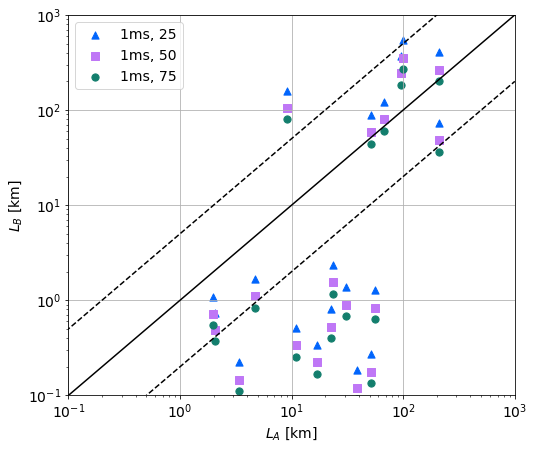

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# Recorded Depths
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]']

h1 = ax.scatter(LA_with_records, av_merged['Lb [km] (1ms 25)'], s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, av_merged['Lb [km] (1ms 50)'], s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, av_merged['Lb [km] (1ms 75)'], s=52, marker='o', c='xkcd:blue green') 
refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.grid('on')
plt.legend([h1, h2, h3], ['1ms, 25', '1ms, 50', '1ms, 75'])
ax.set_xlabel('$L_A$ [km]')
ax.set_ylabel('$L_B$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text

font = {'family' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# Recorded Depths
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['Lb [km] (recorded)'] > 0]
LB_rec_with_records = av_merged['Lb [km] (recorded)'][av_merged['Lb [km] (recorded)'] > 0]

h1 = ax.scatter(av_merged['Lb [km] (K&J, 2018)'], av_merged['LA [km]'], s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LB_rec_with_records, LA_with_records, s=52, marker='s', c='xkcd:light purple') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.grid('on')
plt.legend([h1, h2], ['K&J', 'Recorded Depth'])

ax.set_xlabel('$L_A$ [km]')
ax.set_ylabel('$L_B$ [km]')
ax.set_ylim(bottom=0.1, top=1000)
ax.set_xlim(left=0.1, right=1000)

annotate_text = []

# 

for idx, row in av_merged.iterrows():
    ax.annotate(row.River, xy=(row['Lb [km] (K&J, 2018)'], row['LA [km]']), xytext=(20, -20), xycoords='data', textcoords='offset points')
#     annotate_text.append(plt.text(row['Lb [km] (K&J, 2018)'], row['LA [km]'], row.River, fontsize=14, weight="bold",
#                                   bbox=dict(facecolor='red', alpha=0.6)))
    
# 

# adjust_text(annotate_text, x=av_merged['LA [km]'], y=av_merged['Lb [km] (K&J, 2018)'], va='center', ha='center', precision=0.001,
#             expand_text=(1.1, 1.1), expand_points=(1.05, 1.05),
#             force_text=(0.1, 0.1), force_points=(0.1, 0.1))
    
    

<ipython-input-22-1939562416ff>:12: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-22-1939562416ff>:13: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


<ipython-input-24-6f4de40fb95b>:11: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-24-6f4de40fb95b>:12: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


<ipython-input-24-6f4de40fb95b>:43: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-24-6f4de40fb95b>:44: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


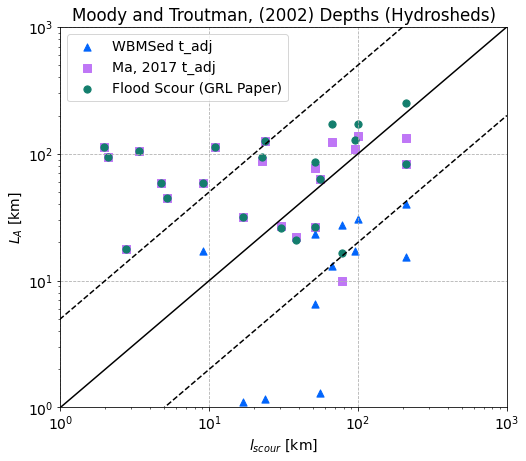

<ipython-input-24-6f4de40fb95b>:76: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-24-6f4de40fb95b>:77: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


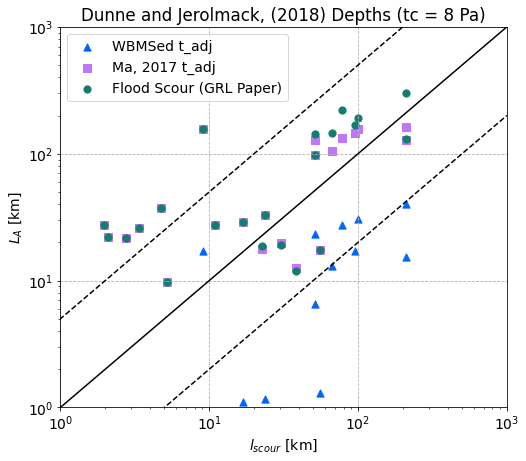

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

font = {'family' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

# Recorded Depths
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {rec}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {rec}'][av_merged['L_scour (WBMSed) [km] {rec}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {rec}'][av_merged['L_scour (Ma, 2017) [km] {rec}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {rec}'][av_merged['L_scour (GRL paper) [km] {rec}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=52, marker='o', c='xkcd:blue green') 
refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])


ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Recorded Depths')
plt.show()

# Moody and Troutman, 2002 Depths (Hydrosheds)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {MT}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {MT}'][av_merged['L_scour (WBMSed) [km] {MT}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {MT}'][av_merged['L_scour (Ma, 2017) [km] {MT}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {MT}'][av_merged['L_scour (GRL paper) [km] {MT}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=52, marker='o', c='xkcd:blue green') 

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])


ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Moody and Troutman, (2002) Depths (Hydrosheds)')
plt.show()


# Dunne and Jerolmack, 2018 Depths (tc = 8 Pa)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {KJ}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {KJ}'][av_merged['L_scour (WBMSed) [km] {KJ}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {KJ}'][av_merged['L_scour (Ma, 2017) [km] {KJ}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {KJ}'][av_merged['L_scour (GRL paper) [km] {KJ}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=52, marker='o', c='xkcd:blue green') 

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])

ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Dunne and Jerolmack, (2018) Depths (tc = 8 Pa)')
plt.show()




<ipython-input-25-16f6ed7a6bb6>:3: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-25-16f6ed7a6bb6>:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


<ipython-input-25-16f6ed7a6bb6>:33: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-25-16f6ed7a6bb6>:34: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


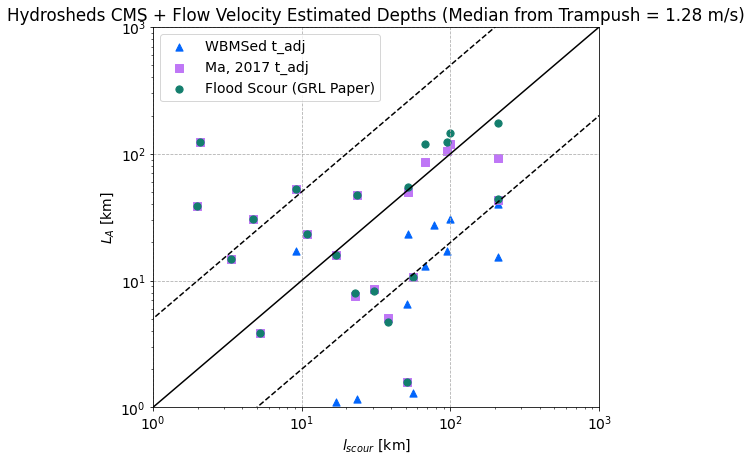

<ipython-input-25-16f6ed7a6bb6>:63: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-25-16f6ed7a6bb6>:64: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


In [25]:
# ~ 1m/s velocity
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {1ms 25}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {1ms 25}'][av_merged['L_scour (WBMSed) [km] {1ms 25}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {1ms 25}'][av_merged['L_scour (Ma, 2017) [km] {1ms 25}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {1ms 25}'][av_merged['L_scour (GRL paper) [km] {1ms 25}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=52, marker='o', c='xkcd:blue green') 

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])

ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Hydrosheds CMS + Flow Velocity Estimated Depths (25th PCT from Trampush = '+str(round(Trampush_velocities['25'],2))+' m/s)')
plt.show()

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {1ms 50}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {1ms 50}'][av_merged['L_scour (WBMSed) [km] {1ms 50}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {1ms 50}'][av_merged['L_scour (Ma, 2017) [km] {1ms 50}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {1ms 50}'][av_merged['L_scour (GRL paper) [km] {1ms 50}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=52, marker='o', c='xkcd:blue green') 

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])

ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Hydrosheds CMS + Flow Velocity Estimated Depths (Median from Trampush = '+str(round(Trampush_velocities['50'],2))+' m/s)')
plt.show()

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {1ms 75}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {1ms 75}'][av_merged['L_scour (WBMSed) [km] {1ms 75}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {1ms 75}'][av_merged['L_scour (Ma, 2017) [km] {1ms 75}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {1ms 75}'][av_merged['L_scour (GRL paper) [km] {1ms 75}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=52, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=52, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=52, marker='o', c='xkcd:blue green') 

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])

ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Hydrosheds CMS + Flow Velocity Estimated Depths (75th PCT from Trampush = '+str(round(Trampush_velocities['75'],2))+' m/s)')
plt.show()


In [26]:
# Dunne and Jerolmack, 2018 Depths (tc = 8 Pa)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_with_records = av_merged['LA [km]'][av_merged['L_scour (WBMSed) [km] {KJ}'] > 0]
WBMSed_Lscour_with_records =  av_merged['L_scour (WBMSed) [km] {KJ}'][av_merged['L_scour (WBMSed) [km] {KJ}'] > 0]
Ma_Lscour_with_records =  av_merged['L_scour (Ma, 2017) [km] {KJ}'][av_merged['L_scour (Ma, 2017) [km] {KJ}'] > 0]
GRL_Lscour_with_records =  av_merged['L_scour (GRL paper) [km] {KJ}'][av_merged['L_scour (GRL paper) [km] {KJ}'] > 0]

h1 = ax.scatter(LA_with_records, WBMSed_Lscour_with_records, s=av_merged['S [-]']*100000, marker='^', c='xkcd:bright blue') 
h2 = ax.scatter(LA_with_records, Ma_Lscour_with_records, s=av_merged['S [-]']*100000, marker='s', c='xkcd:light purple') 
h3 = ax.scatter(LA_with_records, GRL_Lscour_with_records, s=av_merged['S [-]']*100000, marker='o', c='xkcd:blue green') 
refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2, h3], ['WBMSed t_adj', 'Ma, 2017 t_adj', 'Flood Scour (GRL Paper)'])


ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')
plt.grid(True,which="major", linestyle='--')
plt.title('Dunne and Jerolmack, (2018) Depths (tc = 8 Pa)')
plt.show()


<ipython-input-26-bf1fdd2ac388>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-26-bf1fdd2ac388>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


In [27]:
# Dunne and Jerolmack, 2018 Depths (tc = 8 Pa)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_study = av_merged['LA [km]'][av_merged['From'] == 'study']
Ma_Lscour_study =  av_merged['L_scour (Ma, 2017) [km] {KJ}'][av_merged['From'] == 'study']

LA_not_study = av_merged['LA [km]'][av_merged['From'] != 'study']
Ma_not_study =  av_merged['L_scour (Ma, 2017) [km] {KJ}'][av_merged['From'] != 'study']


h1 = ax.scatter(LA_study, Ma_Lscour_study, s=50, marker='^', c='xkcd:coral') 
h2 = ax.scatter(LA_not_study, Ma_not_study, s=50, marker='s', c='xkcd:cobalt') 
refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2], ['This Study (D50 = 0.3 mm)', 'GRL Paper (global + Mad.)'])


ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')

plt.title('Dunne and Jerolmack, (2018) Depths (tc = 8 Pa)')
plt.grid(True,which="major", linestyle='--')
plt.show()


<ipython-input-27-4c931c32f544>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-27-4c931c32f544>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


In [37]:
# Dunne and Jerolmack, 2018 Depths (tc = 8 Pa)

fig, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_study = av_merged['LA [km]'][av_merged['From'] == 'study']
Ma_Lscour_study =  av_merged['L_scour (GRL paper) [km] {KJ}'][av_merged['From'] == 'study']

LA_not_study = av_merged['LA [km]'][av_merged['From'] != 'study']
Ma_not_study =  av_merged['L_scour (GRL paper) [km] {KJ}'][av_merged['From'] != 'study']


h1 = ax.scatter(Ma_Lscour_study, LA_study, s=50, marker='^', c='xkcd:coral') 
h2 = ax.scatter(Ma_not_study, LA_not_study, s=50, marker='s', c='xkcd:cobalt') 
refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')

plt.legend([h1, h2], ['This Study', 'GRL Paper (global + Mad.)'])


ax.set_ylim(bottom=1, top=1000)
ax.set_xlim(left=1, right=1000)
ax.set_ylabel('$L_A$ [km]')
ax.set_xlabel('$l_{scour}$ [km]')

plt.title('Dunne and Jerolmack, (2018) Depths (tc = 8 Pa)')
plt.grid(True,which="major", linestyle='--')
plt.show()


<ipython-input-37-ef11dd96cada>:4: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-37-ef11dd96cada>:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


In [28]:
a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)

D50_trampush(0.299291838, 0.001346939)/1000

4.6959365070931e-06